In [1]:
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import random

from simplecryoem.emfiles import load_data

from simplecryoem.preprocess import preprocess
from simplecryoem.forwardmodel import Slice
from simplecryoem.optimization import Loss, GradV, sgd, get_sgd_vol_ops, precon_sgd
from simplecryoem.utils import mip_x

In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
pwd

'/ceph.groups/scheres_grp/btoader/Code/simplecryoem/notebooks'

In [4]:
#data_dir = "../../../RELION_TUTORIAL_SET/"
#star_file = "particles.star"

data_dir = "../../../Relion5_SPA_tutorial/"
star_file = "Refine3D/job029/run_data.star"

In [5]:
params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

print(f"params0 keys: {params0.keys()}")
print(f"imgs0.shape = {imgs0.shape}")

load_data: number of partcles: 4452
load_data: data loaded, time:  1.49 sec.
params0 keys: dict_keys(['ctf_params', 'pixel_size', 'angles', 'shifts'])
imgs0.shape = (4452, 256, 256)


In [6]:
processed_data = preprocess(imgs0, params0)

imgs0.shape = (4452, 256, 256)
pixel_size0.shape = (4452,)
angles0.shape = (4452, 3)
shifts0.shape = (4452, 2)
ctf_params0.shape = (4452, 9)
N0 = 4452
idx not provided
N = 4452
Taking FFT of the images:
Batch 1/10  0.46 sec.
Batch 2/10  0.46 sec.
Batch 3/10  0.46 sec.
Batch 4/10  0.46 sec.
Batch 5/10  0.46 sec.
Batch 6/10  0.46 sec.
Batch 7/10  0.46 sec.
Batch 8/10  0.46 sec.
Batch 9/10  0.46 sec.
Batch 10/10  0.46 sec.
FFT done. Time:  5.06 sec.
x_grid = [3.13873258e-03 2.56000000e+02]
Vectorised imgs_f.shape = (4452, 65536)
Mask radius = 0.39861903801512377
Noise free, setting sigma_noise = 1


In [7]:
key = random.PRNGKey(20)

In [8]:
N = 4000

key, subkey = random.split(key)
idx_shuffle = random.permutation(subkey, N)

In [9]:
# Images and image-specific parameters
# (orientation angles, in-plane shifts, ctf parameters)

imgs_f = processed_data["imgs_f"][idx_shuffle]
angles = processed_data["angles"][idx_shuffle]
shifts = processed_data["shifts"][idx_shuffle]
ctf_params = processed_data["ctf_params"][idx_shuffle]

# These parameters are the same for all images
pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

In [10]:
# Use the x=0 slice of the 3D mask output by the preprocess function
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [12]:
# Regularization parameter
alpha = 1e-8

slice_obj_tri = Slice(x_grid, mask=mask, interp_method="tri")
loss_obj_tri = Loss(slice_obj_tri, alpha=alpha)
gradv_obj_tri = GradV(loss_obj_tri)

slice_obj_nn = Slice(x_grid, mask=mask, interp_method="nn")
loss_obj_nn = Loss(slice_obj_nn, alpha=alpha)
gradv_obj_nn = GradV(loss_obj_nn)

In [13]:
grad_func_tri1, loss_func_tri1, hvp_func_tri1, _ = get_sgd_vol_ops(
    gradv_obj_tri, loss_obj_tri, angles[:N//2], shifts[:N//2], ctf_params[:N//2], imgs_f[:N//2], sigma_noise
)

grad_func_tri2, loss_func_tri2, hvp_func_tri2, _ = get_sgd_vol_ops(
    gradv_obj_tri, loss_obj_tri, angles[N//2:], shifts[N//2:], ctf_params[N//2:], imgs_f[N//2:], sigma_noise
)

In [14]:
grad_func_nn1, loss_func_nn1, hvp_func_nn1, _ = get_sgd_vol_ops(
    gradv_obj_nn, loss_obj_nn, angles[:N//2], shifts[:N//2], ctf_params[:N//2], imgs_f[:N//2], sigma_noise
)

grad_func_nn2, loss_func_nn2, hvp_func_nn2, _ = get_sgd_vol_ops(
    gradv_obj_nn, loss_obj_nn, angles[N//2:], shifts[N//2:], ctf_params[N//2:], imgs_f[N//2:], sigma_noise
)

### SGD

In [15]:
# Initialization
v0 = jnp.zeros((nx, nx, nx))
D0 = jnp.ones(v0.shape)

N_epochs = 100
batch_size = 200
step_size = 1
c = 0.9

# Parameters specific to preconditioned SGD,
# see the documentation of precon_sgd for details.
beta = 0.5
thresh = 1e-6

In [16]:
N_epochs = 100


In [17]:
key, key_alg = random.split(key)

v_sgdp_tri1, loss_sgdp_tri1, _, _ = precon_sgd(
    key_alg,
    loss_func_tri1,
    grad_func_tri1,
    hvp_func_tri1,
    v0,
    step_size,
    D0,
    beta,
    thresh,
    N_epochs,
    batch_size,
    N//2,
    c=c,
    adaptive_step_size=True,
    iter_display=1,
)

Epoch 1/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it, eta=9.675e-02, loss=1.717e+09]


  Loss =  1.74314334e+09
  eta = 0.09674588159999999
  alpha= 1e-06
Epoch 2/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.74it/s, eta=3.023e-03, loss=1.744e+09]


  Loss =  1.74085642e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 3/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.72it/s, eta=3.023e-03, loss=1.738e+09]


  Loss =  1.73851066e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 4/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.91it/s, eta=6.047e-03, loss=1.739e+09]


  Loss =  1.73564431e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 5/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.93it/s, eta=6.047e-03, loss=1.728e+09]


  Loss =  1.73333268e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 6/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.86it/s, eta=6.047e-03, loss=1.732e+09]


  Loss =  1.73009078e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 7/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.81it/s, eta=6.047e-03, loss=1.731e+09]


  Loss =  1.72712881e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 8/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.90it/s, eta=6.047e-03, loss=1.723e+09]


  Loss =  1.72467121e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 9/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.94it/s, eta=1.209e-02, loss=1.716e+09]


  Loss =  1.72239385e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 10/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s, eta=1.209e-02, loss=1.717e+09]


  Loss =  1.71991366e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 11/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.87it/s, eta=6.047e-03, loss=1.719e+09]


  Loss =  1.71837155e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 12/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.01it/s, eta=1.209e-02, loss=1.716e+09]


  Loss =  1.71650220e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 13/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.89it/s, eta=6.047e-03, loss=1.718e+09]


  Loss =  1.71491488e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 14/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.94it/s, eta=1.209e-02, loss=1.711e+09]


  Loss =  1.71368587e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 15/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.89it/s, eta=6.047e-03, loss=1.713e+09]


  Loss =  1.71259331e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 16/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s, eta=1.209e-02, loss=1.717e+09]


  Loss =  1.71218590e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 17/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s, eta=1.209e-02, loss=1.708e+09]


  Loss =  1.71138360e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 18/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.07it/s, eta=2.419e-02, loss=1.700e+09]


  Loss =  1.71061468e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 19/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.00it/s, eta=1.209e-02, loss=1.712e+09]


  Loss =  1.70932364e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 20/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.91it/s, eta=6.047e-03, loss=1.720e+09]


  Loss =  1.70839012e+09
  eta = 0.006046617599999999
  alpha= 1e-06


In [18]:
key, key_alg = random.split(key)

v_sgdp_tri2, loss_sgdp_tri2, _, _ = precon_sgd(
    key_alg,
    loss_func_tri2,
    grad_func_tri2,
    hvp_func_tri2,
    v0,
    step_size,
    D0,
    beta,
    thresh,
    N_epochs,
    batch_size,
    N//2,
    c=c,
    adaptive_step_size=True,
    iter_display=1,
)

Epoch 1/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.58it/s, eta=9.675e-02, loss=1.720e+09]


  Loss =  1.74189077e+09
  eta = 0.09674588159999999
  alpha= 1e-06
Epoch 2/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s, eta=3.023e-03, loss=1.740e+09]


  Loss =  1.73914933e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 3/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.81it/s, eta=3.023e-03, loss=1.739e+09]


  Loss =  1.73685823e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 4/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.94it/s, eta=6.047e-03, loss=1.730e+09]


  Loss =  1.73401532e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 5/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.91it/s, eta=6.047e-03, loss=1.730e+09]


  Loss =  1.73088964e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 6/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.92it/s, eta=6.047e-03, loss=1.728e+09]


  Loss =  1.72777117e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 7/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.92it/s, eta=6.047e-03, loss=1.726e+09]


  Loss =  1.72505016e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 8/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.91it/s, eta=6.047e-03, loss=1.722e+09]


  Loss =  1.72250741e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 9/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.68it/s, eta=1.512e-03, loss=1.722e+09]


  Loss =  1.72112791e+09
  eta = 0.0015116543999999998
  alpha= 1e-06
Epoch 10/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.81it/s, eta=3.023e-03, loss=1.726e+09]


  Loss =  1.71884394e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 11/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.93it/s, eta=6.047e-03, loss=1.717e+09]


  Loss =  1.71775845e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 12/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.04it/s, eta=1.209e-02, loss=1.714e+09]


  Loss =  1.71584422e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 13/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.00it/s, eta=1.209e-02, loss=1.714e+09]


  Loss =  1.71459568e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 14/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s, eta=1.209e-02, loss=1.713e+09]


  Loss =  1.71293691e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 15/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.08it/s, eta=1.209e-02, loss=1.710e+09]


  Loss =  1.71151432e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 16/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.94it/s, eta=6.047e-03, loss=1.713e+09]


  Loss =  1.71082224e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 17/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s, eta=1.209e-02, loss=1.709e+09]


  Loss =  1.71023389e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 18/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s, eta=1.209e-02, loss=1.708e+09]


  Loss =  1.70933435e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 19/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.87it/s, eta=6.047e-03, loss=1.722e+09]


  Loss =  1.70829866e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 20/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.76it/s, eta=3.023e-03, loss=1.712e+09]


  Loss =  1.70773640e+09
  eta = 0.0030233087999999996
  alpha= 1e-06


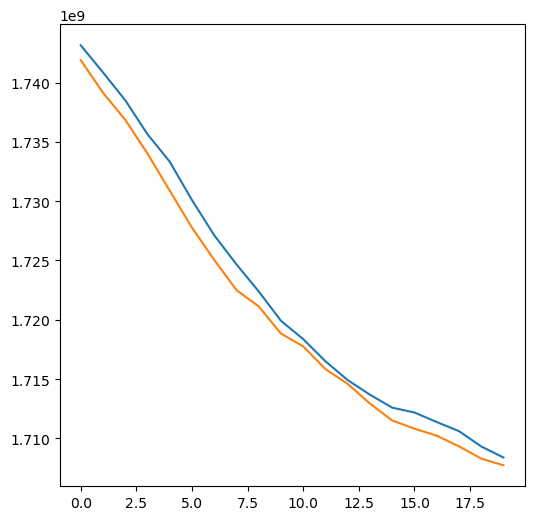

In [19]:
plt.plot(loss_sgdp_tri1)
plt.plot(loss_sgdp_tri2)

In [20]:
from simplecryoem.fsc import calc_fsc

In [21]:
res, fsc, shell_pts = calc_fsc(v_sgdp_tri1, v_sgdp_tri2, [1, nx])

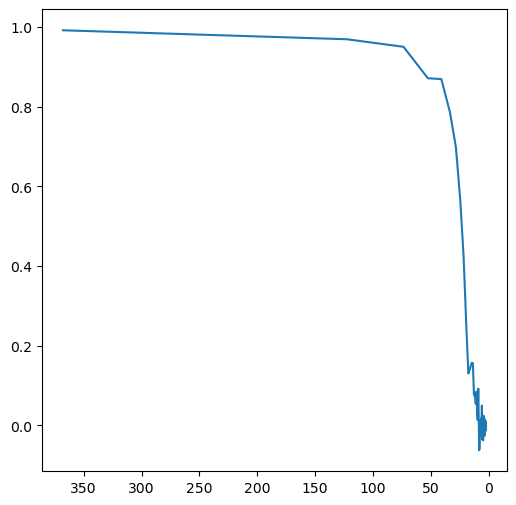

In [22]:
res_angs = nx * pixel_size[0] / res
plt.plot(res_angs[1:], fsc[1:])
plt.gca().invert_xaxis()

In [23]:
N_epochs = 20


In [24]:
key, key_alg = random.split(key)

v_sgdp_nn1, loss_sgdp_nn1, _, _ = precon_sgd(
    key_alg,
    loss_func_nn1,
    grad_func_nn1,
    hvp_func_nn1,
    v0,
    step_size,
    D0,
    beta,
    thresh,
    N_epochs,
    batch_size,
    N//2,
    c=c,
    adaptive_step_size=True,
    iter_display=1,
)

Epoch 1/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s, eta=9.675e-02, loss=1.706e+09]


  Loss =  1.73361492e+09
  eta = 0.09674588159999999
  alpha= 1e-06
Epoch 2/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.37it/s, eta=4.837e-02, loss=1.707e+09]


  Loss =  1.71428981e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 3/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s, eta=4.837e-02, loss=1.698e+09]


  Loss =  1.70755189e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 4/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.30it/s, eta=4.837e-02, loss=1.699e+09]


  Loss =  1.70538278e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 5/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.33it/s, eta=4.837e-02, loss=1.700e+09]


  Loss =  1.70464185e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 6/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s, eta=4.837e-02, loss=1.708e+09]


  Loss =  1.70446664e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 7/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s, eta=4.837e-02, loss=1.704e+09]


  Loss =  1.70452052e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 8/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.33it/s, eta=4.837e-02, loss=1.709e+09]


  Loss =  1.70480174e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 9/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.34it/s, eta=4.837e-02, loss=1.699e+09]


  Loss =  1.70452041e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 10/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s, eta=4.837e-02, loss=1.701e+09]


  Loss =  1.70453377e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 11/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.39it/s, eta=4.837e-02, loss=1.703e+09]


  Loss =  1.70457069e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 12/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s, eta=4.837e-02, loss=1.702e+09]


  Loss =  1.70503918e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 13/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.36it/s, eta=4.837e-02, loss=1.701e+09]


  Loss =  1.70513629e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 14/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.32it/s, eta=4.837e-02, loss=1.705e+09]


  Loss =  1.70475404e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 15/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s, eta=4.837e-02, loss=1.705e+09]


  Loss =  1.70509690e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 16/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.37it/s, eta=4.837e-02, loss=1.703e+09]


  Loss =  1.70515451e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 17/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.37it/s, eta=4.837e-02, loss=1.700e+09]


  Loss =  1.70519744e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 18/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s, eta=4.837e-02, loss=1.707e+09]


  Loss =  1.70519464e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 19/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.33it/s, eta=4.837e-02, loss=1.704e+09]


  Loss =  1.70516740e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 20/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s, eta=4.837e-02, loss=1.706e+09]


  Loss =  1.70520117e+09
  eta = 0.04837294079999999
  alpha= 1e-06


In [25]:
key, key_alg = random.split(key)

v_sgdp_nn2, loss_sgdp_nn2, _, _ = precon_sgd(
    key_alg,
    loss_func_nn2,
    grad_func_nn2,
    hvp_func_nn2,
    v0,
    step_size,
    D0,
    beta,
    thresh,
    N_epochs,
    batch_size,
    N//2,
    c=c,
    adaptive_step_size=True,
    iter_display=1,
)

Epoch 1/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.29it/s, eta=9.675e-02, loss=1.694e+09]


  Loss =  1.73217213e+09
  eta = 0.09674588159999999
  alpha= 1e-06
Epoch 2/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.29it/s, eta=4.837e-02, loss=1.702e+09]


  Loss =  1.71288162e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 3/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.28it/s, eta=4.837e-02, loss=1.705e+09]


  Loss =  1.70611054e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 4/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.33it/s, eta=4.837e-02, loss=1.703e+09]


  Loss =  1.70408177e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 5/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s, eta=4.837e-02, loss=1.706e+09]


  Loss =  1.70340982e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 6/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.27it/s, eta=4.837e-02, loss=1.701e+09]


  Loss =  1.70333148e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 7/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.32it/s, eta=4.837e-02, loss=1.703e+09]


  Loss =  1.70334836e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 8/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s, eta=4.837e-02, loss=1.704e+09]


  Loss =  1.70382144e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 9/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.34it/s, eta=4.837e-02, loss=1.704e+09]


  Loss =  1.70385753e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 10/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.26it/s, eta=4.837e-02, loss=1.701e+09]


  Loss =  1.70385938e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 11/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.34it/s, eta=4.837e-02, loss=1.702e+09]


  Loss =  1.70344117e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 12/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.26it/s, eta=4.837e-02, loss=1.704e+09]


  Loss =  1.70338184e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 13/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.29it/s, eta=4.837e-02, loss=1.705e+09]


  Loss =  1.70382061e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 14/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s, eta=4.837e-02, loss=1.699e+09]


  Loss =  1.70346943e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 15/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.33it/s, eta=4.837e-02, loss=1.702e+09]


  Loss =  1.70326678e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 16/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s, eta=4.837e-02, loss=1.702e+09]


  Loss =  1.70376322e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 17/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.32it/s, eta=4.837e-02, loss=1.704e+09]


  Loss =  1.70391172e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 18/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s, eta=4.837e-02, loss=1.698e+09]


  Loss =  1.70396174e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 19/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.32it/s, eta=4.837e-02, loss=1.697e+09]


  Loss =  1.70350651e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 20/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s, eta=4.837e-02, loss=1.703e+09]


  Loss =  1.70385654e+09
  eta = 0.04837294079999999
  alpha= 1e-06


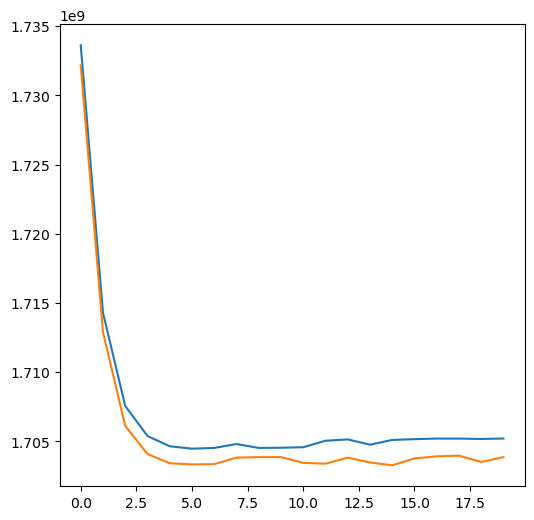

In [26]:
plt.plot(loss_sgdp_nn1)
plt.plot(loss_sgdp_nn2)


In [27]:
res_nn, fsc_nn, shell_pts = calc_fsc(v_sgdp_nn1, v_sgdp_nn2, [1, nx])

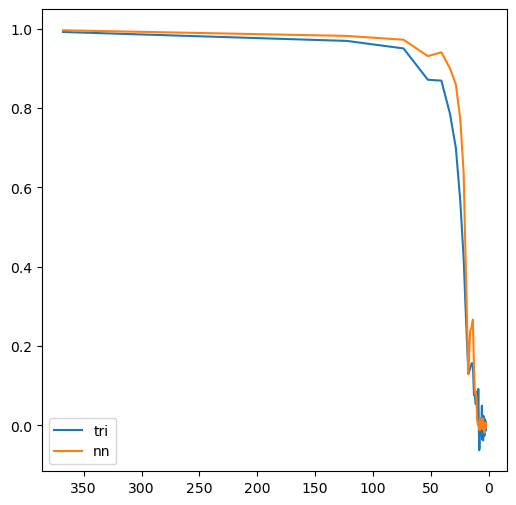

In [28]:
res_angs = nx * pixel_size[0] / res

plt.plot(res_angs, fsc)
plt.plot(res_angs, fsc_nn)
plt.legend(['tri', 'nn'])
plt.gca().invert_xaxis()

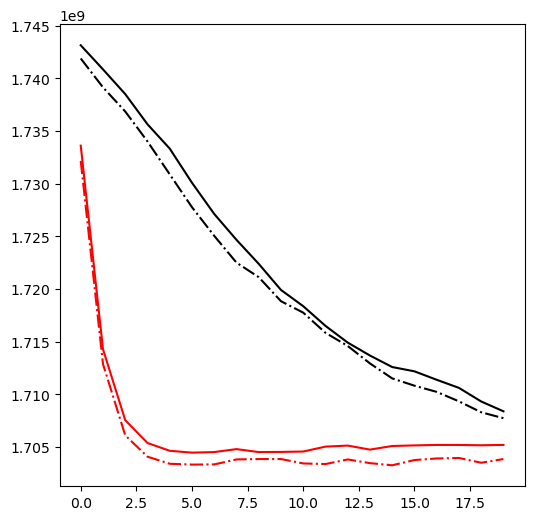

In [29]:
plt.plot(loss_sgdp_nn1, 'r-')
plt.plot(loss_sgdp_nn2, 'r-.')

plt.plot(loss_sgdp_tri1, 'k-')
plt.plot(loss_sgdp_tri2, 'k-.')



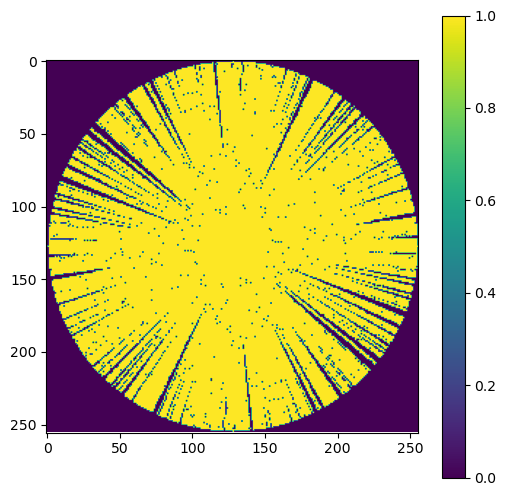

In [30]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_sgdp_nn1[0]))>1)
plt.colorbar()